# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75. 

Алгоритм выполнения задачи:
1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Описание данных
Данные находятся в файле `/datasets/toxic_comments.csv.` Столбец text в нём содержит текст комментария, а toxic — целевой признак.

## 1. Загрузка и подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re 
from time import time

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import torch
import transformers
from tqdm import notebook
from pymystem3 import Mystem
from nltk.corpus import stopwords 
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm
tqdm.pandas()
from sklearn.compose import ColumnTransformer
import random
from sklearn.metrics import f1_score, make_scorer, classification_report

RANDOM_STATE = np.random.randint(12345)
STOP_WORDS = list(stopwords.words('english'))

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'C:/Users/Солнышко/Documents/toxic_comments.csv'
pth3 = 'C:/Users/Home/Documents/Яндекс/Сатанист/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=0)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=0)
elif os.path.exists(pth3):
    data = pd.read_csv(pth3, index_col=0)
else:
    print('Something is wrong')

In [3]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


У нас 160 тысяч строк и 2 колонки - с изначальным текстом и таргетом. Для начала, лемматизируем и очистим текст:

In [4]:
corpus = data['text'].values

def clear_text(text):
    cleared = re.sub(r'[^a-zA-Z]', ' ', text).split()
    return ' '.join(cleared)

# Проверим:
print("Исходный текст:", corpus[0])
print()
print("Очищенный текст:", clear_text(corpus[0]))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Очищенный текст: Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now


In [5]:
clear_data = pd.DataFrame(data['text'].apply(clear_text), index = data.index)
clear_data['text'] = clear_data['text'].str.lower()
clear_data

,text
0,explanation why the edits made under my userna...
1,d aww he matches this background colour i m se...
2,hey man i m really not trying to edit war it s...
3,more i can t make any real suggestions on impr...
4,you sir are my hero any chance you remember wh...
...,...
159446,and for the second time of asking when your vi...
159447,you should be ashamed of yourself that is a ho...
159448,spitzer umm theres no actual article for prost...
159449,and it looks like it was actually you who put ...


Текст очистили, переходим к лемматизации:

In [6]:
# Лемматизация занимает достаточно много времени, но это один из основных процессов. 
# Для облегчения понимания, на каком этапе лемматизация, добавим progress_apply
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


def lemmatization(row):
    lemmatizer = WordNetLemmatizer()
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(row))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None: 
            lemmatized_sentence.append(word)
        else: 
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return ' '.join(lemmatized_sentence)

data['lemm_text'] = clear_data['text'].progress_apply(lambda x: lemmatization(x))
data['lemm_text'].head(10)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [20:02<00:00, 132.44it/s]


0    explanation why the edits make under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not try to edit war it s ju...
3    more i can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
5    congratulation from me as well use the tool we...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense be offensive to you...
9    alignment on this subject and which be contrar...
Name: lemm_text, dtype: object

Посмотрим соотношение классов:

In [7]:
print(data['toxic'].value_counts())
(data['toxic'].value_counts()[0]/data['toxic'].value_counts()[1])

toxic
0    143106
1     16186
Name: count, dtype: int64


8.841344371679229

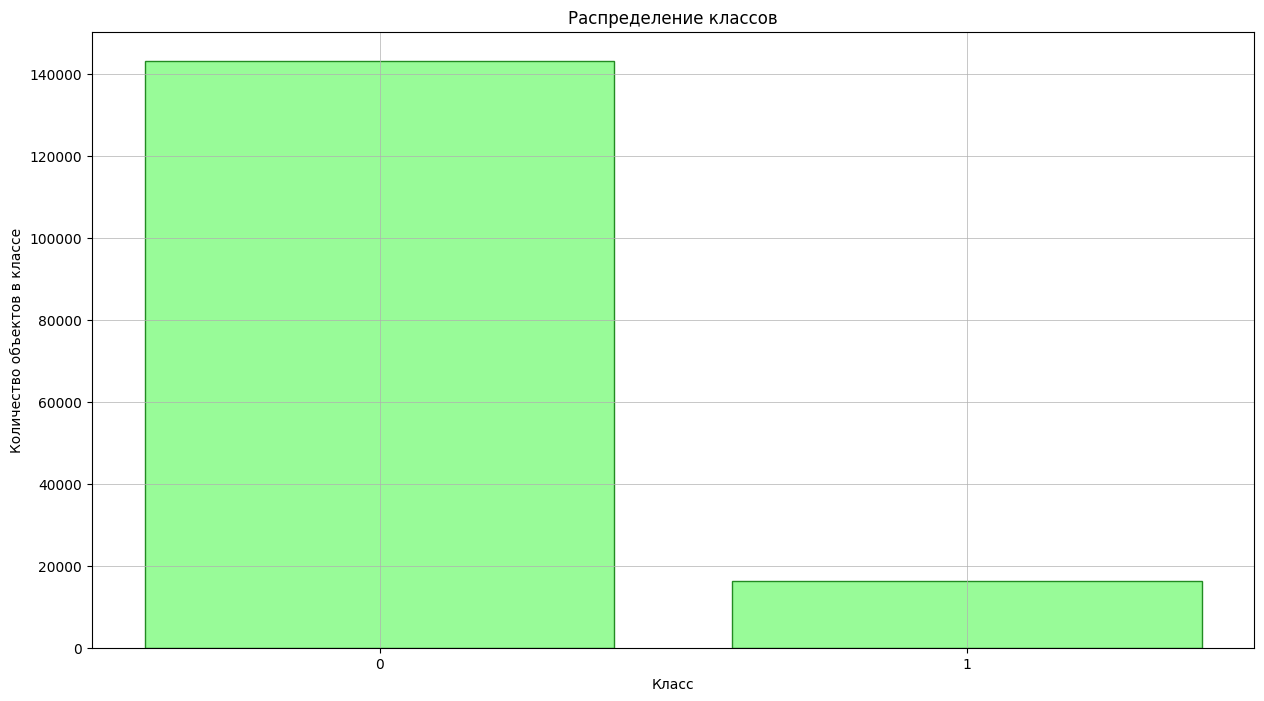

In [8]:
plt.figure(figsize=(15, 8))
elements, count = np.unique(data['toxic'], return_counts=True)
plt.bar(elements, count, color = 'palegreen', edgecolor='forestgreen')
plt.xticks(elements)
plt.xlabel('Класс')
plt.ylabel('Количество объектов в классе')
plt.title('Распределение классов')
plt.grid(linewidth=0.5); 

Количество нетоксичных комментариев превосходит количество токсичных в 8 раз.

In [9]:
features = data['lemm_text']
target = data['toxic']
# будем делать кросс-валидацию, поэтому разбиваем на 2 выборки: обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state = RANDOM_STATE)

In [10]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(127433,) (31859,) (127433,) (31859,)


In [27]:
# векторизируем наш текст:
vect = TfidfVectorizer(stop_words=list(STOP_WORDS))
tfidf_train = vect.fit_transform(features_train)
tfidf_test = vect.transform(features_test)

In [28]:
print(tfidf_train.shape, tfidf_test.shape)

(127433, 137118) (31859, 137118)


## 2. Обучение моделей

Добавим результирующую таблицу:

In [32]:
res = pd.DataFrame(index=range(0,5), columns = ['model','params', 'best_f1','fit_time','pred_time'])
res

,model,params,best_f1,fit_time,pred_time
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


И пару необходимых функций:

In [38]:
score = make_scorer(f1_score, greater_is_better = True)

def return_best_model(model, params, features, target):
    
    pipeline = Pipeline(steps=[
        ('vect', TfidfVectorizer(stop_words=STOP_WORDS)), 
        ('clf', model)])
    
    search = RandomizedSearchCV(pipeline, param_distributions = params, cv=3, 
                                    scoring = score, random_state=RANDOM_STATE, verbose=4)
    print('start search')
    search.fit(features, target)
    print(f'best params: {search.best_params_}')
    print(f'best score: {search.best_score_}')
    
    start_fit = time()
    search.best_estimator_.fit(features, target)
    end_fit = time()
    fit_time = (end_fit-start_fit)/60
    print(f'fit time: {fit_time} min')
    start_pred = time()
    predictions = search.best_estimator_.predict(features)
    end_pred = time()
    pred_time = (end_pred-start_pred)/60
    print(f'pred time: {pred_time} min')
                
    return search, fit_time, pred_time

### LogisticRegression:

In [41]:
model = LogisticRegression()
params_lr = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.1, 1, 5, 10, 15],
    'clf__solver':['lbfgs', 'liblinear', 'sag', 'saga']}

search, fit_time, pred_time = return_best_model(model, params_lr, features_train, target_train)
res.loc[0] = [model, search.best_params_, search.best_score_, fit_time, pred_time]

start search
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END clf__C=1, clf__penalty=l1, clf__solver=saga;, score=0.769 total time=  21.3s
[CV 2/3] END clf__C=1, clf__penalty=l1, clf__solver=saga;, score=0.766 total time=  20.4s
[CV 3/3] END clf__C=1, clf__penalty=l1, clf__solver=saga;, score=0.763 total time=  23.5s
[CV 1/3] END clf__C=10, clf__penalty=l2, clf__solver=liblinear;, score=0.773 total time=   6.9s
[CV 2/3] END clf__C=10, clf__penalty=l2, clf__solver=liblinear;, score=0.770 total time=   6.9s
[CV 3/3] END clf__C=10, clf__penalty=l2, clf__solver=liblinear;, score=0.770 total time=   6.9s
[CV 1/3] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear;, score=0.460 total time=   6.0s
[CV 2/3] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear;, score=0.472 total time=   9.5s
[CV 3/3] END clf__C=0.1, clf__penalty=l2, clf__solver=liblinear;, score=0.469 total time=  16.7s
[CV 1/3] END clf__C=15, clf__penalty=l1, clf__solver=saga;, score=0.771 total

### DecisionTree

In [45]:
model = DecisionTreeClassifier()

params_dtc = {'clf__splitter':['best', 'random'],
              'clf__max_depth':[5, 10, 25, 50],
              'clf__criterion':['gini', 'entropy','log_loss']}

search, fit_time, pred_time = return_best_model(model, params_dtc, features_train, target_train)
res.loc[1] = [model, search.best_params_, search.best_score_, fit_time, pred_time]

start search
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END clf__criterion=entropy, clf__max_depth=5, clf__splitter=random;, score=0.354 total time=  19.3s
[CV 2/3] END clf__criterion=entropy, clf__max_depth=5, clf__splitter=random;, score=0.466 total time=  20.2s
[CV 3/3] END clf__criterion=entropy, clf__max_depth=5, clf__splitter=random;, score=0.411 total time=  19.5s
[CV 1/3] END clf__criterion=gini, clf__max_depth=10, clf__splitter=random;, score=0.547 total time=  25.2s
[CV 2/3] END clf__criterion=gini, clf__max_depth=10, clf__splitter=random;, score=0.544 total time=  27.6s
[CV 3/3] END clf__criterion=gini, clf__max_depth=10, clf__splitter=random;, score=0.523 total time=  25.7s
[CV 1/3] END clf__criterion=entropy, clf__max_depth=10, clf__splitter=random;, score=0.550 total time=  22.6s
[CV 2/3] END clf__criterion=entropy, clf__max_depth=10, clf__splitter=random;, score=0.519 total time=  23.0s
[CV 3/3] END clf__criterion=entropy, clf__max_depth=10, cl

### LightGBM

In [46]:
model = LGBMClassifier(verbose=-1)

params_lgbm = {'clf__boosting_type':['gbdt','dart','rf'],
               'clf__learning_rate':[0.01, 0.03, 0.05]}

search, fit_time, pred_time = return_best_model(model, params_lgbm, features_train, target_train)
res.loc[2] = [model, search.best_params_, search.best_score_, fit_time, pred_time]

start search
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END clf__boosting_type=gbdt, clf__learning_rate=0.01;, score=0.551 total time=  57.6s
[CV 2/3] END clf__boosting_type=gbdt, clf__learning_rate=0.01;, score=0.557 total time=  54.6s
[CV 3/3] END clf__boosting_type=gbdt, clf__learning_rate=0.01;, score=0.565 total time=  54.8s
[CV 1/3] END clf__boosting_type=gbdt, clf__learning_rate=0.03;, score=0.680 total time=  55.7s
[CV 2/3] END clf__boosting_type=gbdt, clf__learning_rate=0.03;, score=0.674 total time=  55.0s
[CV 3/3] END clf__boosting_type=gbdt, clf__learning_rate=0.03;, score=0.674 total time=  55.3s
[CV 1/3] END clf__boosting_type=gbdt, clf__learning_rate=0.05;, score=0.708 total time=  54.3s
[CV 2/3] END clf__boosting_type=gbdt, clf__learning_rate=0.05;, score=0.708 total time=  53.8s
[CV 3/3] END clf__boosting_type=gbdt, clf__learning_rate=0.05;, score=0.705 total time=  56.2s
[CV 1/3] END clf__boosting_type=dart, clf__learning_rate=0.01;, score=0.

### CatBoost

In [48]:
model = CatBoostClassifier(verbose=False)

params_cb = {'clf__iterations':[100, 200],
             'clf__learning_rate':[0.01, 0.03]}

search, fit_time, pred_time = return_best_model(model, params_cb, features_train, target_train)
res.loc[3] = [model, search.best_params_, search.best_score_, fit_time, pred_time]

start search
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END clf__iterations=100, clf__learning_rate=0.01;, score=0.468 total time= 3.7min
[CV 2/3] END clf__iterations=100, clf__learning_rate=0.01;, score=0.485 total time= 3.8min
[CV 3/3] END clf__iterations=100, clf__learning_rate=0.01;, score=0.488 total time= 3.8min
[CV 1/3] END clf__iterations=100, clf__learning_rate=0.03;, score=0.536 total time= 3.7min
[CV 2/3] END clf__iterations=100, clf__learning_rate=0.03;, score=0.520 total time= 3.8min
[CV 3/3] END clf__iterations=100, clf__learning_rate=0.03;, score=0.530 total time= 3.8min
[CV 1/3] END clf__iterations=200, clf__learning_rate=0.01;, score=0.506 total time= 6.0min
[CV 2/3] END clf__iterations=200, clf__learning_rate=0.01;, score=0.502 total time= 5.8min
[CV 3/3] END clf__iterations=200, clf__learning_rate=0.01;, score=0.508 total time= 5.9min
[CV 1/3] END clf__iterations=200, clf__learning_rate=0.03;, score=0.604 total time= 5.8min
[CV 2/3] END clf_

### LinearSVC

In [49]:
model = LinearSVC()

params_lsvc = {'clf__C': [0.1, 1, 10],
               'clf__max_iter': [100, 1000, 2000],
               'clf__penalty': ['l1', 'l2'],
               'clf__dual': [True, False]}

search, fit_time, pred_time = return_best_model(model, params_lsvc, features_train, target_train)
res.loc[4] = [model, search.best_params_, search.best_score_, fit_time, pred_time]

start search
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END clf__C=1, clf__dual=False, clf__max_iter=2000, clf__penalty=l2;, score=0.777 total time=   7.6s
[CV 2/3] END clf__C=1, clf__dual=False, clf__max_iter=2000, clf__penalty=l2;, score=0.771 total time=   6.9s
[CV 3/3] END clf__C=1, clf__dual=False, clf__max_iter=2000, clf__penalty=l2;, score=0.770 total time=   6.3s
[CV 1/3] END clf__C=1, clf__dual=True, clf__max_iter=1000, clf__penalty=l2;, score=0.777 total time=   5.7s
[CV 2/3] END clf__C=1, clf__dual=True, clf__max_iter=1000, clf__penalty=l2;, score=0.771 total time=   5.9s
[CV 3/3] END clf__C=1, clf__dual=True, clf__max_iter=1000, clf__penalty=l2;, score=0.770 total time=   6.2s
[CV 1/3] END clf__C=0.1, clf__dual=True, clf__max_iter=2000, clf__penalty=l2;, score=0.724 total time=   6.0s
[CV 2/3] END clf__C=0.1, clf__dual=True, clf__max_iter=2000, clf__penalty=l2;, score=0.723 total time=   5.4s
[CV 3/3] END clf__C=0.1, clf__dual=True, clf__max_iter=

In [50]:
res = res.sort_values('best_f1', ascending=False)
res

,model,params,best_f1,fit_time,pred_time
4,LinearSVC(),"{'clf__penalty': 'l1', 'clf__max_iter': 100, '...",0.776448,0.126311,0.083354
0,LogisticRegression(),"{'clf__solver': 'liblinear', 'clf__penalty': '...",0.770949,0.334711,0.242976
2,LGBMClassifier(verbose=-1),"{'clf__learning_rate': 0.05, 'clf__boosting_ty...",0.70739,1.184035,0.356603
1,DecisionTreeClassifier(),"{'clf__splitter': 'best', 'clf__max_depth': 50...",0.697429,3.788923,0.259043
3,<catboost.core.CatBoostClassifier object at 0x...,"{'clf__learning_rate': 0.03, 'clf__iterations'...",0.598717,3.755162,0.110179


## 3. Выводы

На тестовой выборке мы будем проверять опорные вектора. У них самая высокая f1 мера - а значит, и по точности, и по полноте модель показывает себя лучше всех. К тому же, у них достаточно небольшое время обучения и предсказания.

In [59]:
def return_best_model(model, params, features_train, target_train, features_test):
    
    pipeline = Pipeline(steps=[
        ('vect', TfidfVectorizer(stop_words=STOP_WORDS)), 
        ('clf', model)])
    
    search = RandomizedSearchCV(pipeline, param_distributions = params, cv=3, 
                                    scoring = score, random_state=RANDOM_STATE)
    search.fit(features, target)
    search.best_estimator_.fit(features, target)
    predictions = search.best_estimator_.predict(features_test)
                
    return predictions

In [60]:
model = LinearSVC()

params_lsvc = {'clf__C': [1],
               'clf__max_iter': [100],
               'clf__penalty': ['l1'],
               'clf__dual': [False]}

pred = return_best_model(model, params_lsvc, features_train, target_train, features_test)
print(f'''{classification_report(target_test, pred)}

final f1 score: {f1_score(target_test, pred)}''')

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     28574
           1       0.94      0.80      0.87      3285

    accuracy                           0.97     31859
   macro avg       0.96      0.90      0.93     31859
weighted avg       0.97      0.97      0.97     31859


final f1 score: 0.8661856346343063


Нужный нам порог f1-меры в 0.75 пройден.

# Итоговый вывод

В ходе проекта необходимо было обучить модель определять негативные и позитивные комментарии на сайте интернет магазина. В ходе работ мы загрузили, изучили и подготовили данные, обучили 5 моделей: `LogisticRegression, LinearSVC, DecisionTreeClassifier, LightGBM и CatBoost`, а также определили лучшую модель - ею стала `LinearSVC` по соотношению f1 меры, времени обучения и предсказания.